<a href="https://colab.research.google.com/github/eugenemfu/DUL_HW/blob/main/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 361 (delta 108), reused 92 (delta 67), pack-reused 171
Receiving objects: 100% (361/361), 55.83 MiB | 31.65 MiB/s, done.
Resolving deltas: 100% (169/169), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./

In [2]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

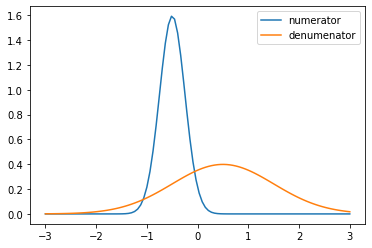

In [ ]:
# distributions

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils import data
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

device = 'cuda'

In [ ]:
class KMM(nn.Module):   
    def __init__(self, hidden=128):
        super().__init__()
        self.r = nn.Sequential(
            nn.Linear(1, hidden), 
            nn.ReLU(),
            nn.Linear(hidden, hidden), 
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Softplus()
        )
    
    def kernel(self, x1, x2):
        res = rbf_kernel(x1.cpu().detach().numpy(), x2.cpu().detach().numpy())
        return torch.tensor(res).to(device)
   
    def fit(self, data_nu, data_de, n_epochs=200):
        dl_nu = data.DataLoader(data_nu, batch_size=512)
        dl_de = data.DataLoader(data_de, batch_size=512)
        opt = optim.Adam(self.r.parameters())

        for epoch in tqdm(range(n_epochs)):
            for batch_nu, batch_de in zip(dl_nu, dl_de):
                batch_nu = batch_nu.unsqueeze(1).float().to(device)
                batch_de = batch_de.unsqueeze(1).float().to(device)

                batch_nu_pred = self.r(batch_de)
                k_de_de = self.kernel(batch_de, batch_de)
                k_de_nu = self.kernel(batch_de, batch_nu)
                loss = (batch_nu_pred.T.matmul(k_de_de).matmul(batch_nu_pred) - 2 * batch_nu_pred.T.matmul(k_de_nu).sum())

                opt.zero_grad()
                loss.backward()
                opt.step()


In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  kmm = KMM().to(device)
  kmm.fit(data_nu, data_de)
  x = np.linspace(-2., 2, num=100)
  ans = kmm.r(torch.tensor(x).unsqueeze(1).float().to(device)).cpu().detach().numpy()
  return ans

100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


<Figure size 432x288 with 0 Axes>

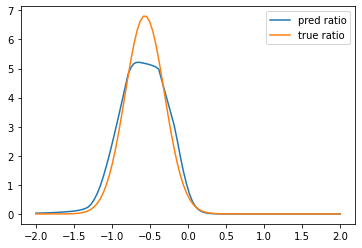

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [29]:
class Classifier(nn.Module):
    def __init__(self, ld, hd):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(),
        )
        self.seq2 = nn.Sequential(
            nn.Linear(4 * 4 * 128 + ld, hd), 
            nn.ReLU(),
            nn.Linear(hd, hd), 
            nn.ReLU(),
            nn.Linear(hd, 1),
        )
  
    def forward(self, x, z):
        return self.seq2(torch.cat([self.seq1(x).flatten(1), z], 1))


class Encoder(nn.Module):
    def __init__(self, ld, nd):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(),
        )
        self.fc = nn.Linear(4 * 4 * 128 + nd, ld)

    def forward(self, x, noise):
        return self.fc(torch.cat([self.seq(x).flatten(1), noise], 1))


class Decoder(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(ld, 4 * 4 * 128),
            nn.ReLU()
        )
  
    def forward(self, x):
        return self.seq(self.fc(x).reshape(-1, 128, 4, 4))


class AVB(nn.Module):
    def __init__(self, ld, hd, nd):
        super().__init__()
        self.classifier = Classifier(ld, hd)
        self.encoder = Encoder(ld, nd)
        self.decoder = Decoder(ld)

        self.latent_dist = MultivariateNormal(torch.zeros(ld), torch.eye(ld))
        self.noise_dist = MultivariateNormal(torch.zeros(nd), torch.eye(nd))

    def fit(self, train_data, test_data, epoch_num, batch_size=256):
        train_data = 2 * train_data.transpose(0, 3, 1, 2) - 1
        test_data = 2 * test_data.transpose(0, 3, 1, 2) - 1
        train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

        opt = optim.Adam(list(self.encoder.parameters()) +
                   list(self.decoder.parameters()), lr=1e-3)
        opt_cls = optim.Adam(self.classifier.parameters(), lr=1e-3)

        train_elbo_losses = []
        train_cls_losses = []
        test_elbo_losses = []
        test_cls_losses = []
        
        elbo_loss, cls_loss = self.test(test_dataloader)
        test_elbo_losses.append(elbo_loss)
        test_cls_losses.append(cls_loss)

        for epoch in tqdm(range(epoch_num)):
            for batch in train_dataloader:
                batch = batch.to(device).float()
                elbo_loss, cls_loss = self.loss(batch)

                opt.zero_grad()
                elbo_loss.backward()
                opt.step()
                train_elbo_losses.append(elbo_loss.item())

                opt_cls.zero_grad()
                cls_loss.backward()
                opt_cls.step()
                train_cls_losses.append(cls_loss.item())

            elbo_loss, cls_loss = self.test(test_dataloader)
            test_elbo_losses.append(elbo_loss)
            test_cls_losses.append(cls_loss)
          
        return tuple(map(np.array, (train_elbo_losses, 
                                    train_cls_losses, 
                                    test_elbo_losses, 
                                    test_cls_losses)))
        
    def loss(self, x_true):
        noise = self.noise_dist.sample((x_true.shape[0],)).to(device)
        encoded = self.encoder(x_true, noise)
        x_pred = self.decoder(encoded)
        mse_loss = F.mse_loss(x_true, x_pred, reduction='none').sum(dim=[1, 2, 3])
        elbo_loss = (mse_loss + self.classifier(x_true, encoded)).mean()
        noise = self.noise_dist.sample((x_true.shape[0],)).to(device)
        z_fake = self.latent_dist.sample((x_true.shape[0],)).to(device)
        with torch.no_grad():
            z_true = self.encoder(x_true, noise)
        y_true = torch.sigmoid(self.classifier(x_true, z_true))
        y_fake = torch.sigmoid(self.classifier(x_true, z_fake))
        scores = torch.cat([y_true, y_fake])
        labels = torch.cat([torch.ones_like(y_true), torch.zeros_like(y_fake)])
        cls_loss = F.binary_cross_entropy(scores, labels)
        return elbo_loss, cls_loss
    
    @torch.no_grad()
    def test(self, test_dataloader):
        elbo_losses = []
        cls_losses = []
        for batch in test_dataloader:
            batch = batch.to(device).float()
            elbo_loss, cls_loss = self.loss(batch)
            elbo_losses.append(elbo_loss.item())
            cls_losses.append(cls_loss.item())
        return np.mean(elbo_losses), np.mean(cls_losses)

    @torch.no_grad()
    def sample(self, n):
        sample = self.decoder(self.latent_dist.sample((n,)).to(device))
        sample = (sample.clip(-1, 1) + 1) / 2
        return sample.cpu().numpy()

In [30]:
def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    model = AVB(64, 128, 5).to(device)
    return (*model.fit(train_data, test_data, 10), model.sample(100))

100%|██████████| 10/10 [09:56<00:00, 59.63s/it]


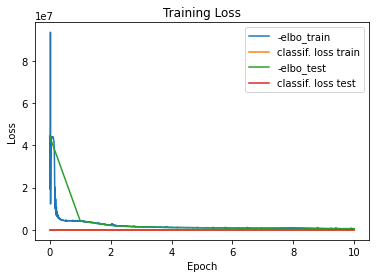

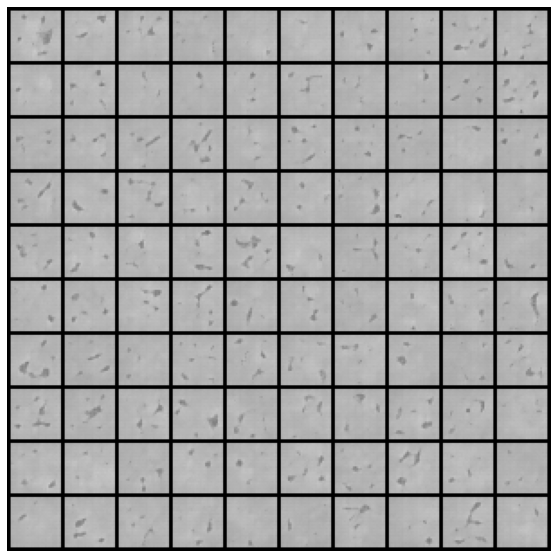

In [31]:
q2_results(q2)